In [1]:
import sys
sys.path.insert(0,'/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/marusy/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [2]:
#import h5py

from operator_assembler.assembly_interface import AssemblyInterface2D
from operator_assembler.n_to_1_ddof_allocator import Nto1Allocator2D
from grid.grid_manager import GridManager
from grid.allocator_interface import InterfaceDofAllocator2D
from grid.grid_domain import GridDomain
from operator_assembler.matrix_assembler import MatrixAssembler2D
from scipy.ndimage import imread
from grid import cell, grid_layer, grid_manager
import h5py
import numpy as np

from common import visual
from common.tests import *
from common.helpers import *
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import linalg

%matplotlib inline

#### Bad cell

In [ ]:
data_start = (16, 20)
data_shape = (4, 4)
data_end = tuple([i+j for i,j in zip(data_start, data_shape)])

h5_data = h5py.File('../../../GM_L3D/600/state/viz_GM_1.h5')['index'][0]
data = h5_data[data_start[0]:data_end[0], data_start[1]:data_end[1]]
#data = imread('/Users/marusy/Programming/model/bhi2_labelled0000.tif')[data_start[0]:data_end[0], data_start[1]:data_end[1]]

grid_domain = GridDomain(integer_size=data_shape, domain_size=(1.,1.))
gm = GridManager()
ifma = InterfaceDofAllocator2D(grid_manager=gm.fit(data=data))

gm.draw_grid()

In [3]:
cell1 = cell.Cell2D(size=(1,1), ll_vertex=(0,0))
cell2 = cell.Cell2D(size=(1,1), ll_vertex=(0,1))

cell3 = cell.Cell2D(size=(2,2), ll_vertex=(1,0))

In [4]:
layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2]], layer_number=0, index=[1,1], div_index=[1,1])
layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3]], layer_number=1, index=[1], div_index=[1])

In [5]:
gm = grid_manager.GridManager(dim=2, method='coarse2to1')
gm.grid_layers = [layer1, layer2]
ifma = InterfaceDofAllocator2D(grid_manager=gm)

In [6]:
ma = Nto1Allocator2D(grid_interface=ifma)
ma._make_ddof_index()
grid_domain = GridDomain(domain_size=(3.,2.), integer_size=(3,2))
grid_domain.make_pointwise_index(ma)

In [7]:
ifma2 = AssemblyInterface2D(allocator=ma)
MA = MatrixAssembler2D(assembly_interface=ifma2, grid_domain=grid_domain)
deep = MA.assemble()

[(0, 4), (1, 36), (2, 37), (3, 38), (4, 39), (5, 40), (6, 0), (7, 50), (8, 51), (9, 52), (10, 53), (11, 41), (12, 1), (13, 54), (14, 55), (15, 56), (16, 57), (17, 42), (18, 2), (19, 58), (20, 59), (21, 60), (22, 61), (23, 43), (24, 3), (25, 62), (26, 63), (27, 64), (28, 65), (29, 44), (30, 5), (31, 46), (32, 47), (33, 48), (34, 49), (35, 45)] [(0, 10), (1, 6), (2, 7), (3, 8), (4, 9), (5, 4), (6, 11), (7, 20), (8, 21), (9, 22), (10, 23), (11, 0), (12, 12), (13, 24), (14, 25), (15, 26), (16, 27), (17, 1), (18, 13), (19, 28), (20, 29), (21, 30), (22, 31), (23, 2), (24, 14), (25, 32), (26, 33), (27, 34), (28, 35), (29, 3), (30, 15), (31, 16), (32, 17), (33, 18), (34, 19), (35, 5)]
[(0, 4), (1, 36), (2, 37), (3, 38), (4, 39), (5, 40), (6, 0), (7, 50), (8, 51), (9, 52), (10, 53), (11, 41), (12, 1), (13, 54), (14, 55), (15, 56), (16, 57), (17, 42), (18, 2), (19, 58), (20, 59), (21, 60), (22, 61), (23, 43), (24, 3), (25, 62), (26, 63), (27, 64), (28, 65), (29, 44), (30, 5), (31, 46), (32, 47),

In [ ]:
sine_test = grid_domain.vectorize_function(lambda x,y: np.sin(x+y))
product = grid_domain.devectorize_vector(MA.assembled * sine_test)
init = grid_domain.devectorize_function(lambda x,y: np.sin(x+y))

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_vector(MA.assembled * sine_test),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_function(lambda x,y: np.sin(x+y)),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

In [47]:
def partial_diff_test2(pointnum, point, matrix, pointdict, mass_matrix=None,
                      multiple_dofs_on_point=True):
    x_der = 0
    xx_der = 0
    yy_der = 0
    y_der = 0
    xy_der = 0

    if not multiple_dofs_on_point:
        for k, v in pointdict.items():
            dx = point[0] - k[0]
            dy = point[1] - k[1]

            x_der += dx * matrix[pointnum, v]
            xx_der += matrix[pointnum, v] * dx ** 2 / 2
            y_der += dy * matrix[pointnum, v]
            yy_der += dy ** 2 / 2 * matrix[pointnum, v]
            xy_der += dx * dy * matrix[pointnum, v]
    else:
        for k, vs in pointdict.items():
            for v in vs:
                dx = point[0] - k[0]
                dy = point[1] - k[1]

                x_der += dx * matrix[pointnum, v]
                xx_der += matrix[pointnum, v] * dx ** 2 / 2
                y_der += dy * matrix[pointnum, v]
                yy_der += dy ** 2 / 2 * matrix[pointnum, v]
                xy_der += dx * dy * matrix[pointnum, v]

    if mass_matrix is not None:
        print('Mass coef: {}'.format(mass_matrix[pointnum].sum()))

    print('X derivative: {}'.format(x_der))
    print('Y derivative: {}'.format(y_der))
    print('XX derivative: {}'.format(xx_der))
    print('YY derivative: {}'.format(yy_der))
    print('XY_derivative: {}'.format(xy_der), end='\n\n')
    return (xx_der + yy_der)/2

In [49]:
mm = np.zeros(MA.half_glob.shape[0])
for i in grid_domain.normal_index.keys():
    print(i, end=' ')
    mm[i] = partial_diff_test2(matrix=MA.half_glob, point=grid_domain.normal_index[i], pointnum=i, pointdict=grid_domain.pointwise_index)

0 X derivative: -4.221966803840543e-06
Y derivative: -2.3881041971429706e-06
XX derivative: -0.012613992975463485
YY derivative: -0.012610605059203406
XY_derivative: 7.069365022746577e-07

1 X derivative: 6.009369913279007e-06
Y derivative: -4.212612492310308e-07
XX derivative: -0.01849656186646075
YY derivative: -0.018498150809101454
XY_derivative: -1.45212576437145e-07

2 X derivative: -9.695711520561756e-07
Y derivative: 3.39249237153727e-07
XX derivative: -0.01849511192941617
YY derivative: -0.018495229093413973
XY_derivative: -1.8978146636792342e-06

3 X derivative: -2.629597726611782e-06
Y derivative: -7.225637394699114e-07
XX derivative: -0.012616377086986232
YY derivative: -0.012583099978365046
XY_derivative: 1.1135123127378743e-07

4 X derivative: 0.06667045413127873
Y derivative: 2.582769085913983e-06
XX derivative: -0.0022241535337032634
YY derivative: -0.002223030539304484
XY_derivative: -1.108741097733193e-06

5 X derivative: -0.06666530603450088
Y derivative: -1.217285050

In [54]:
MM = csr_matrix(np.diag(-1/mm))

In [60]:
for i in grid_domain.normal_index.keys():
    print(i, end=' ')
    partial_diff_test(matrix=MM * MA.half_glob, point=grid_domain.normal_index[i], pointnum=i, pointdict=grid_domain.pointwise_index)

0 X derivative: -0.00033474997683269336
Y derivative: -0.0001893472549174824
XX derivative: -1.000134310019744
YY derivative: -0.9998656899802609
XY_derivative: 5.6051359176079174e-05

1 X derivative: 0.0003248772312938464
Y derivative: -2.2774132776959277e-05
XX derivative: -0.9999570494666469
YY derivative: -1.0000429505333508
XY_derivative: -7.850450291613242e-06

2 X derivative: -5.242293665363995e-05
Y derivative: 1.8342585007324885e-05
XX derivative: -0.9999968325785996
YY derivative: -1.0000031674214005
XY_derivative: -0.00010261136346434441

3 X derivative: -0.00020870256314631241
Y derivative: -5.7347518581885026e-05
XX derivative: -1.0013205475865612
YY derivative: -0.9986794524134219
XY_derivative: 8.837582699428026e-06

4 X derivative: 29.983222208379487
Y derivative: 0.0011615301024399116
XX derivative: -1.0002525180834394
YY derivative: -0.999747481916565
XY_derivative: -0.0004986261326600516

5 X derivative: -29.683303887813786
Y derivative: -0.0005420066941308477
XX der

In [10]:
for i in grid_domain.normal_index.keys():
    print(i, end=' ')
    partial_diff_test(matrix=MA.assembled, point=grid_domain.normal_index[i], pointnum=i, pointdict=grid_domain.pointwise_index)

0 X derivative: -4.221966803979321e-06
Y derivative: -2.388104197129093e-06
XX derivative: -0.01261399297546343
YY derivative: -0.012610605059203379
XY_derivative: 7.069365023024132e-07

1 X derivative: 6.009369913084718e-06
Y derivative: -4.212612492587864e-07
XX derivative: -0.018496561866460707
YY derivative: -0.01849815080910137
XY_derivative: -1.45212576437145e-07

2 X derivative: -9.695711520006645e-07
Y derivative: 3.3924923720923816e-07
XX derivative: -0.01849511192941617
YY derivative: -0.018495229093413987
XY_derivative: -1.897814663693112e-06

3 X derivative: -2.629597726611782e-06
Y derivative: -7.225637390258222e-07
XX derivative: -0.012616377086986232
YY derivative: -0.012583099978364824
XY_derivative: 1.1135123127378743e-07

4 X derivative: 0.06667045413127876
Y derivative: 2.582769085900105e-06
XX derivative: -0.0022241535337032842
YY derivative: -0.0022230305393044977
XY_derivative: -1.1087410977227846e-06

5 X derivative: -8.869449444001004e-06
Y derivative: 6.7551062

In [ ]:
MA.I_s2b

In [ ]:
MA.half_glob[2].toarray().flatten()

In [ ]:
deep[0][1].toarray()[[2, 7, 6]]

In [ ]:
deep[0][1][2].toarray()

In [ ]:
deep[0][1][:,16].toarray()

In [ ]:
MA.assembled[2].toarray().flatten()[-9:]

In [ ]:
pipka[2].toarray().flatten()

In [ ]:
partial_diff_test(matrix=deep[0][-1], point=grid_domain.normal_index[2], pointnum=2, pointdict=grid_domain.pointwise_index)

In [ ]:
dist = distributed_eye_easy(ma.get_cell_list_of_ddofs(cell=cell3), axis2shape=MA.assembly_interface.get_ddof_count())

In [ ]:
pipka = dist.T * csr_matrix(MA._get_local_gg_matrix(distribution='lobatto', order=2)) * dist

In [ ]:
mm = np.array(MA.assembled_mass.sum(axis=1)).flatten()

In [ ]:
mm_sp = csr_matrix(np.diag(1/mm))

In [ ]:
op =  mm_sp * MA.assembled 

In [9]:
grid_domain.normal_index

{0: (0.11747235059738159, 1.0),
 1: (0.35738423466682434, 1.0),
 2: (0.64261579513549805, 1.0),
 3: (0.88252764940261841, 1.0),
 4: (0.0, 1.0),
 5: (1.0, 1.0),
 6: (0.0, 0.11747235059738159),
 7: (0.0, 0.35738423466682434),
 8: (0.0, 0.64261579513549805),
 9: (0.0, 0.88252764940261841),
 10: (0.0, 0.0),
 11: (0.11747235059738159, 0.0),
 12: (0.35738423466682434, 0.0),
 13: (0.64261579513549805, 0.0),
 14: (0.88252764940261841, 0.0),
 15: (1.0, 0.0),
 16: (1.0, 0.11747235059738159),
 17: (1.0, 0.35738423466682434),
 18: (1.0, 0.64261579513549805),
 19: (1.0, 0.88252764940261841),
 20: (0.11747235059738159, 0.11747235059738159),
 21: (0.11747235059738159, 0.35738423466682434),
 22: (0.11747235059738159, 0.64261579513549805),
 23: (0.11747235059738159, 0.88252764940261841),
 24: (0.35738423466682434, 0.11747235059738159),
 25: (0.35738423466682434, 0.35738423466682434),
 26: (0.35738423466682434, 0.64261579513549805),
 27: (0.35738423466682434, 0.88252764940261841),
 28: (0.64261579513549

In [ ]:
MA.assembly_interface.allocator.get_cell_list_of_ddofs(cell2)

In [ ]:
plt.imshow(deep[0][-1].toarray(), interpolation='none')

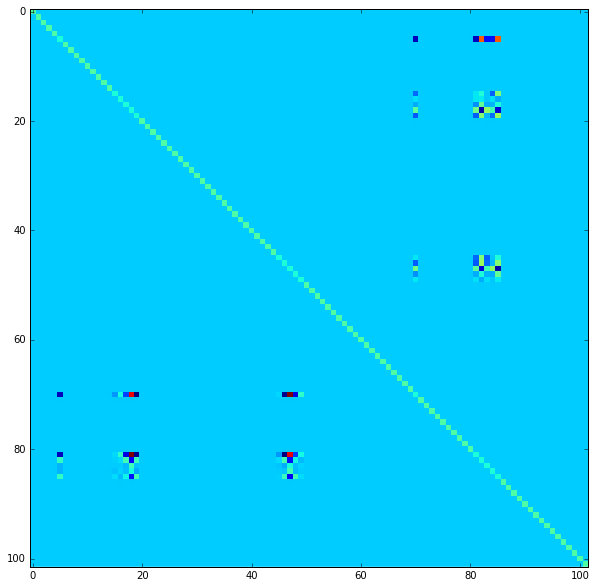

In [14]:
f = plt.figure(figsize=(10,10))
plt.imshow(deep[0][1].toarray(), interpolation='none')

In [16]:
partial_diff_test(matrix=MA.assembled, point=grid_domain.normal_index[85], pointnum=85, pointdict=grid_domain.pointwise_index)

X derivative: 1.73287145303902e-05
Y derivative: 0.0333905808041043
XX derivative: -0.018921087872083995
YY derivative: 0.07346155384293833
XY_derivative: 4.189232185120018e-06



In [17]:
partial_diff_test(matrix=MA.assembled, point=grid_domain.normal_index[19], pointnum=19, pointdict=grid_domain.pointwise_index)

X derivative: -5.719905437840539e-06
Y derivative: 0.009233823525553454
XX derivative: -0.009455989046790968
YY derivative: -0.3608853207864575
XY_derivative: -1.1427716476932956e-05



In [18]:
partial_diff_test(matrix=MA.half_glob, point=grid_domain.normal_index[85], pointnum=85, pointdict=grid_domain.pointwise_index)

X derivative: 0.3784811930437717
Y derivative: -2.3932140867932716e-05
XX derivative: -0.025236257713405784
YY derivative: -0.02523384509684623
XY_derivative: 2.788012706884252e-06



In [19]:
partial_diff_test(matrix=MA.half_glob, point=grid_domain.normal_index[19], pointnum=19, pointdict=grid_domain.pointwise_index)

X derivative: -0.18923611487159922
Y derivative: 2.7381645811796335e-05
XX derivative: -0.0063071761326451824
YY derivative: -0.006323069228967444
XY_derivative: 8.720377302207094e-07



In [20]:
csr_matrix(MA._get_local_gg_matrix(distribution='lobatto', order=2))

<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 81 stored elements in Compressed Sparse Row format>

In [21]:
from common import polynom_factory

In [43]:
mmatrix = polynom_factory.local_funcfunc_matrix(distribution='globatto', order=2, dim=2, size=(0,1))

In [44]:
tomul = np.diag(1/mmatrix.sum(axis=1))

In [45]:
matrix, index = polynom_factory.local_gradgrad_matrix(distribution='globatto', order=2, dim=2)

In [46]:
for point, num in index.items():
    partial_diff_test(matrix=np.dot(tomul, matrix), point=point, pointnum=num, pointdict=index, multiple_dofs_on_point=False)

X derivative: 5.999999999999929
Y derivative: -5.999999999999729
XX derivative: -0.9999999999999458
YY derivative: -0.9999999999998771
XY_derivative: -8.43769498715119e-15

X derivative: -2.2426505097428162e-14
Y derivative: -5.999999999999936
XX derivative: -1.0000000000000135
YY derivative: -0.9999999999999578
XY_derivative: -9.880984919163893e-15

X derivative: 0.0
Y derivative: 5.999999999999963
XX derivative: -0.9999999999999717
YY derivative: -0.9999999999999698
XY_derivative: 0.0

X derivative: -9.2148511043888e-15
Y derivative: -2.2870594307278225e-14
XX derivative: -1.0000000000000064
YY derivative: -1.0000000000000098
XY_derivative: 2.4980018054066022e-15

X derivative: 6.000000000000006
Y derivative: -2.886579864025407e-14
XX derivative: -0.9999999999999837
YY derivative: -1.0000000000000113
XY_derivative: 1.1102230246251565e-15

X derivative: -6.000000000000215
Y derivative: 6.0000000000002025
XX derivative: -1.0000000000000746
YY derivative: -1.0000000000000133
XY_derivati

In [31]:
for point, num in index.items():
    partial_diff_test(matrix=matrix, point=point, pointnum=num, pointdict=index, multiple_dofs_on_point=False)

X derivative: 0.16666666666666624
Y derivative: -0.16666666666666072
XX derivative: -0.027777777777776534
YY derivative: -0.02777777777777462
XY_derivative: -2.42861286636753e-16

X derivative: -2.4424906541753444e-15
Y derivative: -0.6666666666666594
XX derivative: -0.11111111111111258
YY derivative: -0.11111111111110639
XY_derivative: -1.1102230246251565e-15

X derivative: 0.0
Y derivative: 0.6666666666666696
XX derivative: -0.11111111111110916
YY derivative: -0.11111111111110894
XY_derivative: 0.0

X derivative: -3.9968028886505635e-15
Y derivative: -1.021405182655144e-14
XX derivative: -0.44444444444444764
YY derivative: -0.4444444444444492
XY_derivative: 1.1102230246251565e-15

X derivative: 0.6666666666666672
Y derivative: -3.2404634531246757e-15
XX derivative: -0.11111111111110925
YY derivative: -0.1111111111111123
XY_derivative: 1.3183898417423734e-16

X derivative: -0.16666666666666696
Y derivative: 0.16666666666666663
XX derivative: -0.0277777777777789
YY derivative: -0.02777